In [20]:
# Importing Essential Libraries


import numpy as np
import pandas as pd

import xgboost
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from time import time
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



# Any results you write to the current directory are saved as output.

In [2]:
data = pd.read_csv('kc_house_data.csv')
df_train=data.copy()
df_train.rename(columns ={'price': 'SalePrice'}, inplace =True)

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


First of all Data Cleaning Step to be followed ****

In [4]:
print(len(data))
# Check the number of features in the data set
print(len(data.columns))
# Check the data types
print(data.dtypes.unique())

21613
21
[dtype('int64') dtype('O') dtype('float64')]


In [5]:
# Check any number of columns with NaN
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21613


In [6]:
# As id and date columns are not important to predict price so we are discarding it for finding correlation
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name

In [7]:
# Finding Correlation of price woth other variables to see how many variables are strongly correlated with price
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [8]:
# Printing all the correlated features value with respect to price which is target variable
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


As zipcode is negatively correlated with sales price , so we can discard it for sales price prediction.

**Feature Selection******

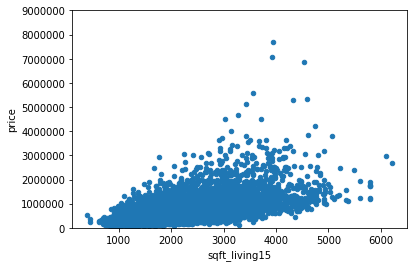

In [9]:
var = 'sqft_living15'
data = pd.concat([data['price'], data[var]], axis=1)
data.plot.scatter(x=var, y='price', ylim=(3,9000000));

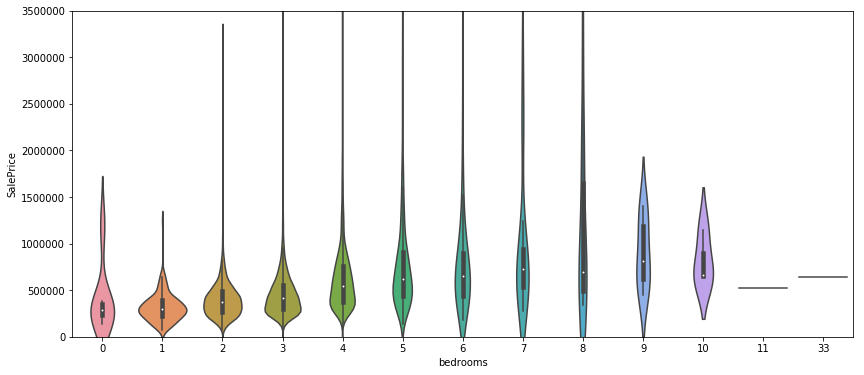

In [10]:
var = 'bedrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.violinplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);




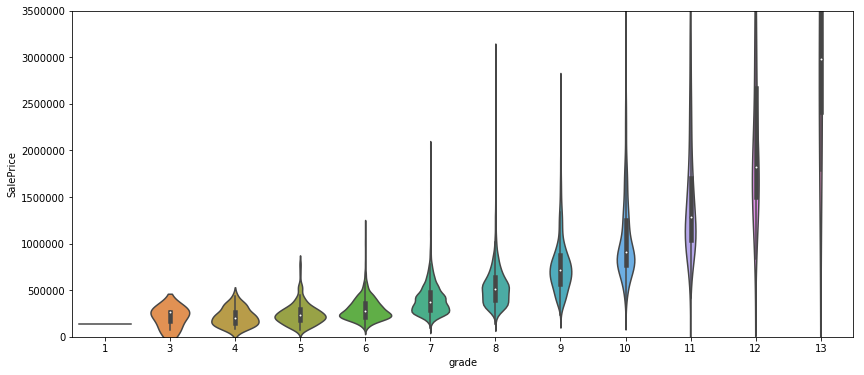

In [11]:
var = 'grade'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.violinplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

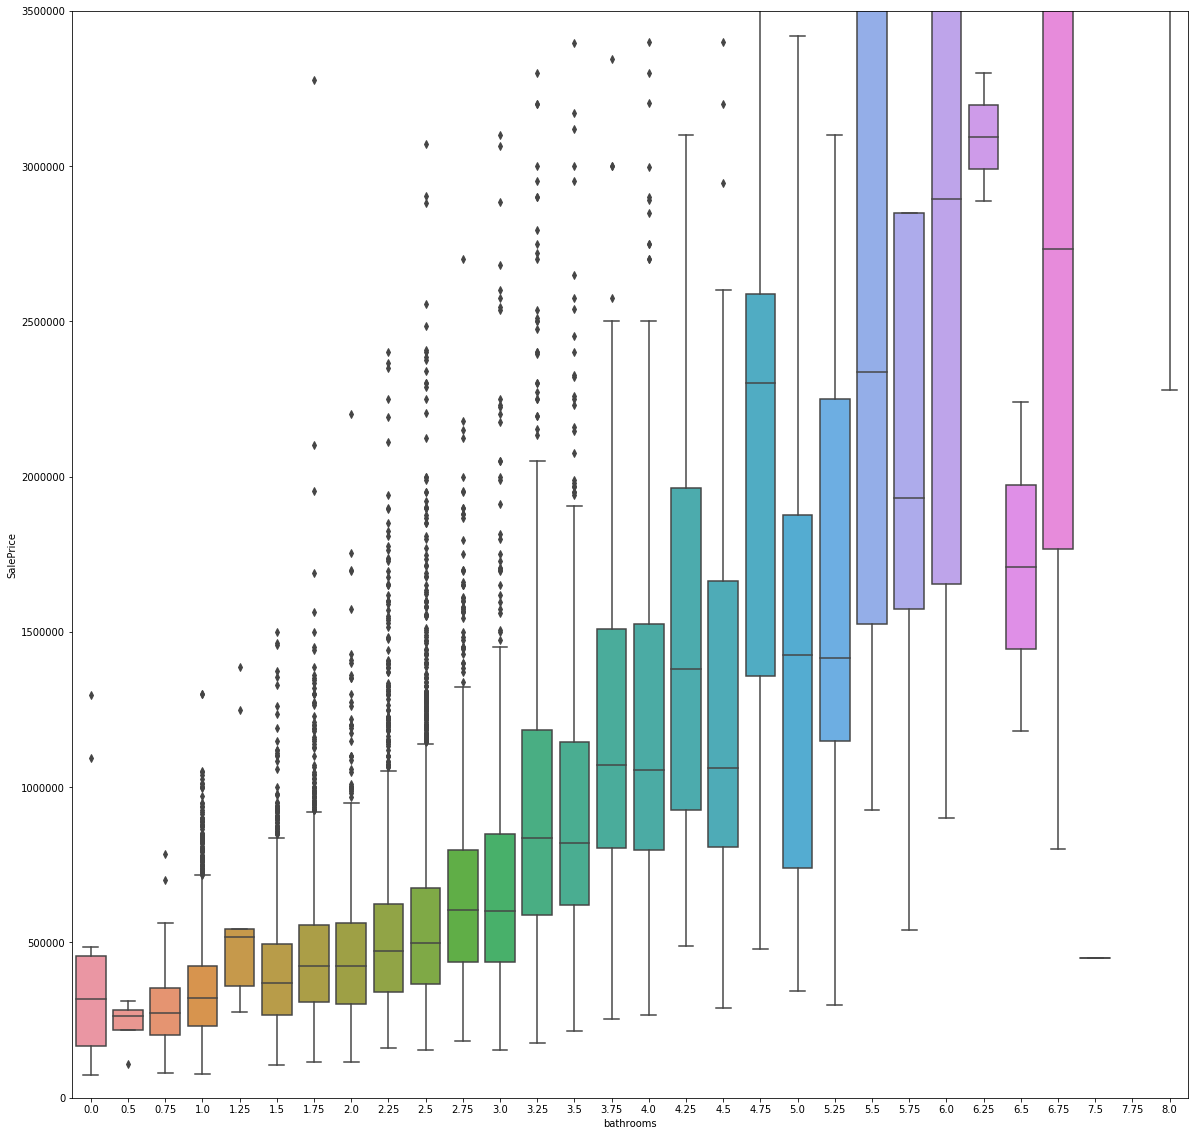

In [12]:
var = 'bathrooms'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

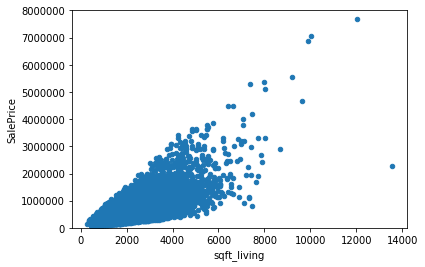

In [13]:
var = 'sqft_living'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(3,8000000));


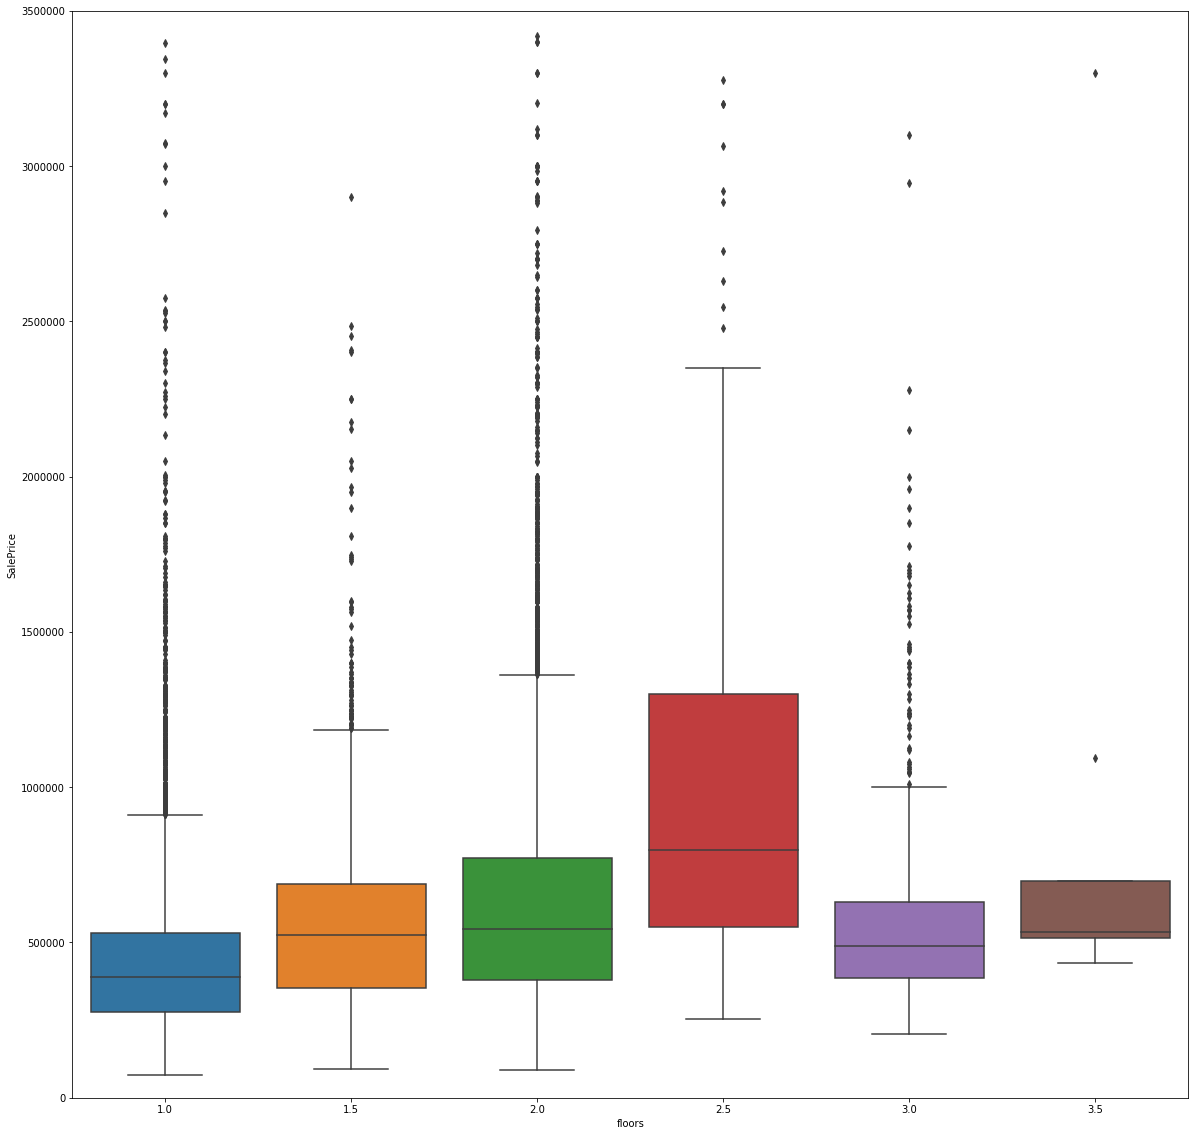

In [14]:
var = 'floors'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=3500000);

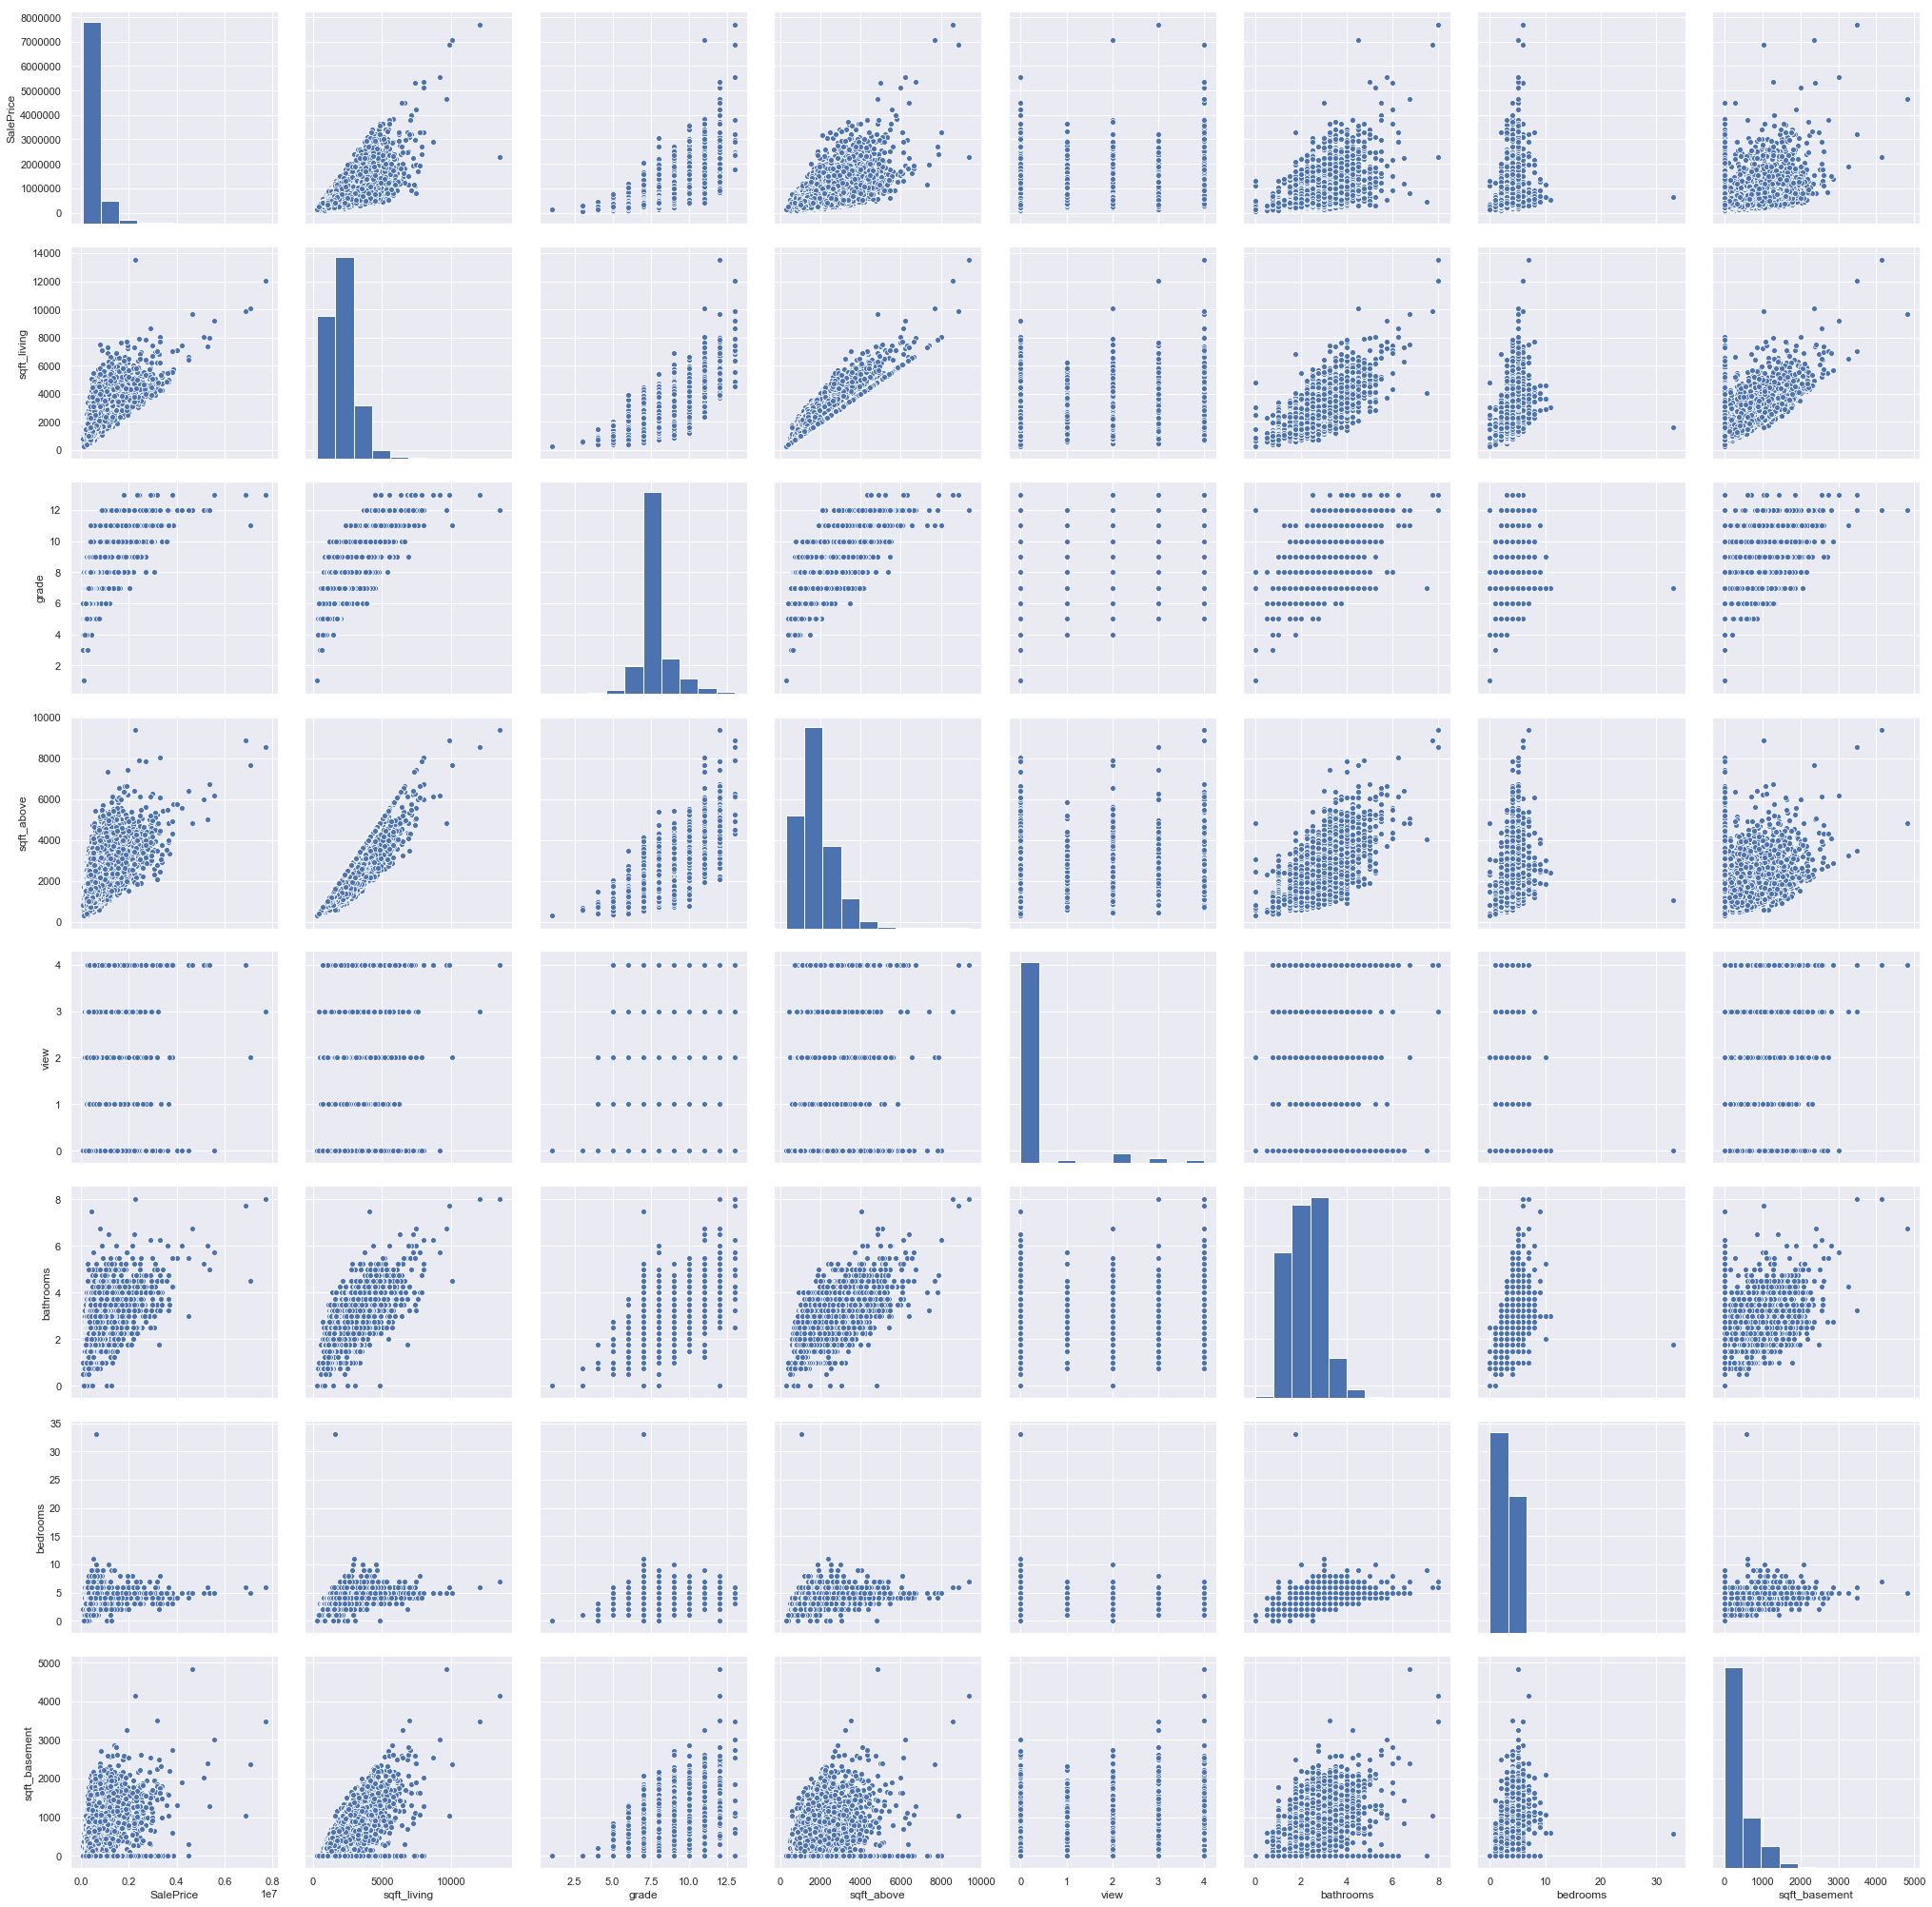

In [15]:
#Pairplots to visualize strong correlation
sns.set()
cols = ['SalePrice', 'sqft_living', 'grade', 'sqft_above', 'view', 'bathrooms','bedrooms','sqft_basement']
sns.pairplot(df_train[cols], height = 3.5)
plt.show();

In [16]:
new_data = df_train[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','waterfront','yr_built','lat','bedrooms','long']]

In [17]:
X = new_data.values
y = df_train.SalePrice.values

In [18]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

In [24]:
rand_regr = RandomForestRegressor(n_estimators=400,random_state=0)
start = time()
rand_regr.fit(X_train, y_train)
end=time()
train_time_rand=end-start
random=rand_regr.score(X_test,y_test)

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
start = time()
est=GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='ls',min_samples_split=2,learning_rate=0.1).fit(X_train, y_train)
end=time()
train_time_g=end-start
gradient=est.score(X_test,y_test)

In [26]:
xgb = xgboost.XGBRegressor(n_estimators=450, learning_rate=0.1, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
start = time()
xgb.fit(X_train, y_train)
end=time()
train_time_x=end-start
xgboost=xgb.score(X_test,y_test)

In [27]:
from sklearn.ensemble import AdaBoostRegressor
start = time()
ada=AdaBoostRegressor(n_estimators=50, learning_rate=0.2,loss='exponential').fit(X_train, y_train)
end=time()
train_time_ada=end-start
pred=ada.predict(X_test)
adab=ada.score(X_test,y_test)


In [28]:
from sklearn.tree  import DecisionTreeRegressor
decision=DecisionTreeRegressor()
start = time()
decision.fit(X_train, y_train)
end=time()
train_time_dec=end-start
decc=decision.score(X_test,y_test)
decpredict=decision.predict(X_test)

In [29]:
# Comparing Accuracy of different models
models_cross = pd.DataFrame({
    'Model': ['Gradient Boosting','XGBoost','AdaBoost','Random Forest','Decision Tree'],
    'Score': [gradient,xgboost,adab,random,decc]})
    
models_cross.sort_values(by='Score', ascending=False)

,Model,Score
1,XGBoost,0.878244
3,Random Forest,0.864844
0,Gradient Boosting,0.863008
4,Decision Tree,0.736431
2,AdaBoost,0.642142


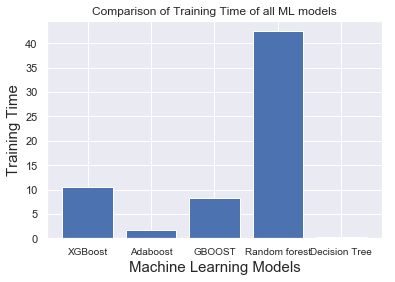

In [57]:
import matplotlib.pyplot as plt
import numpy as np
model = ['XGBoost','Adaboost', 'GBOOST', 'Random forest', 'Decision Tree']
Train_Time = [
    train_time_x,
    train_time_ada,
    train_time_g,
    train_time_rand,
    train_time_dec
    
]
index = np.arange(len(model))
plt.bar(index, Train_Time)
plt.xlabel('Machine Learning Models', fontsize=15)
plt.ylabel('Training Time', fontsize=15)
plt.xticks(index, model, fontsize=10, )
plt.title('Comparison of Training Time of all ML models')
plt.show()

In [58]:
df_train.head()

,SalePrice,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


**Applying Permutation to Improve the Models**

In [36]:
df_train=df_train.drop(['id'],axis=1)

In [40]:
df_train=df_train.drop(['date'],axis=1)

In [42]:
df_train.head()

,SalePrice,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [43]:
feature_names = [i for i in df_train.columns]
X = df_train[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
est=GradientBoostingRegressor(n_estimators=400, max_depth=5, loss='ls',min_samples_split=2,learning_rate=0.1).fit(train_X, train_y)

pred=est.predict(val_X)
gradient=est.score(val_X,val_y)

In [45]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(est, random_state=1).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
1.9073 ± 0.0280,SalePrice
0.0005 ± 0.0000,grade
0.0000 ± 0.0000,sqft_living
0.0000 ± 0.0000,bathrooms
0.0000 ± 0.0000,sqft_basement
0.0000 ± 0.0000,long
0.0000 ± 0.0000,sqft_living15
0.0000 ± 0.0000,sqft_above
0.0000 ± 0.0000,sqft_lot
0.0000 ± 0.0000,floors


In [47]:
unwantedcolumnlist=["SalePrice","bedrooms"]


In [48]:
df = df_train.drop(unwantedcolumnlist, axis=1)

In [55]:
df.head()

,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [49]:
X = df.values
y = df_train.SalePrice.values

In [50]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

In [51]:
from sklearn.ensemble import AdaBoostRegressor
ada=AdaBoostRegressor(n_estimators=50, learning_rate=0.2,loss='exponential').fit(X_train, y_train)

pred=ada.predict(X_test)
adab=ada.score(X_test,y_test)

In [52]:
from sklearn.tree  import DecisionTreeRegressor
decision=DecisionTreeRegressor()
decision.fit(X_train, y_train)
decc=decision.score(X_test,y_test)
decpredict=decision.predict(X_test)

In [53]:
from sklearn.ensemble import RandomForestRegressor
rand_regr = RandomForestRegressor(n_estimators=400,random_state=0)
rand_regr.fit(X_train, y_train)

random=rand_regr.score(X_test,y_test)

In [54]:
models_cross = pd.DataFrame({
    'Model': ['XGBoost','Gradient Boosting','AdaBoost','Random Forest','Decision Tree'],
    'Score': [xgboost,gradient,adab,random,decc]})
    
models_cross.sort_values(by='Score', ascending=False)

,Model,Score
0,Gradient Boosting,0.989529
2,Random Forest,0.831773
3,Decision Tree,0.693226
1,AdaBoost,0.620397


**Conclusion**

So, we have seen that after applying permutation Importance for filtering of features accuracy of gradient boosting has increased manifold to 98.95%.